COMPREHENSIVE COX PH ANALYSIS
Loading data...
PlayList shape: (267005, 15)
InjuryRecord shape: (104, 9)
Loading PlayerTrackData...
PlayerTrackData shape: (25010207, 20)
Correction factor: 5.784

TASK 3: Simple Cox PH (Before Adjustment)

Simple Cox PH Results (Field Type Only):
                    coef  exp(coef)         p  se(coef)
covariate                                              
FieldSynthetic  0.573223   1.773975  0.004351  0.201021

🏈 SIMPLE MODEL RESULT:
   Hazard Ratio (Synthetic): 1.774
   95% CI: [1.196, 2.631]
   → Synthetic turf INCREASES injury hazard by 77.4%

Loading Cox PH + ML Results (After Adjustment)

Adjusted Cox PH Results (Field Type + Movement Patterns):
                    coef  exp(coef)         p  se(coef)
covariate                                              
FieldSynthetic  0.007460   1.007488  0.941228  0.101179
s_std           0.586807   1.798238  0.000500  0.168579
s_max          -0.045353   0.955660  0.851343  0.242005
a_std           0.200954   1

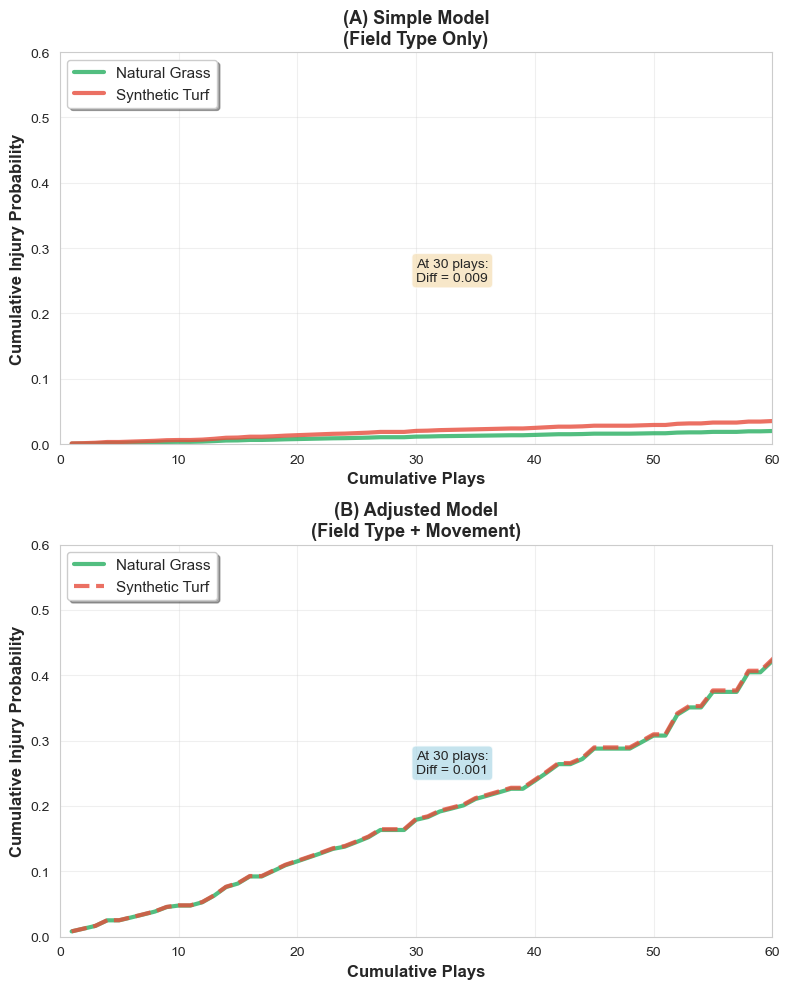

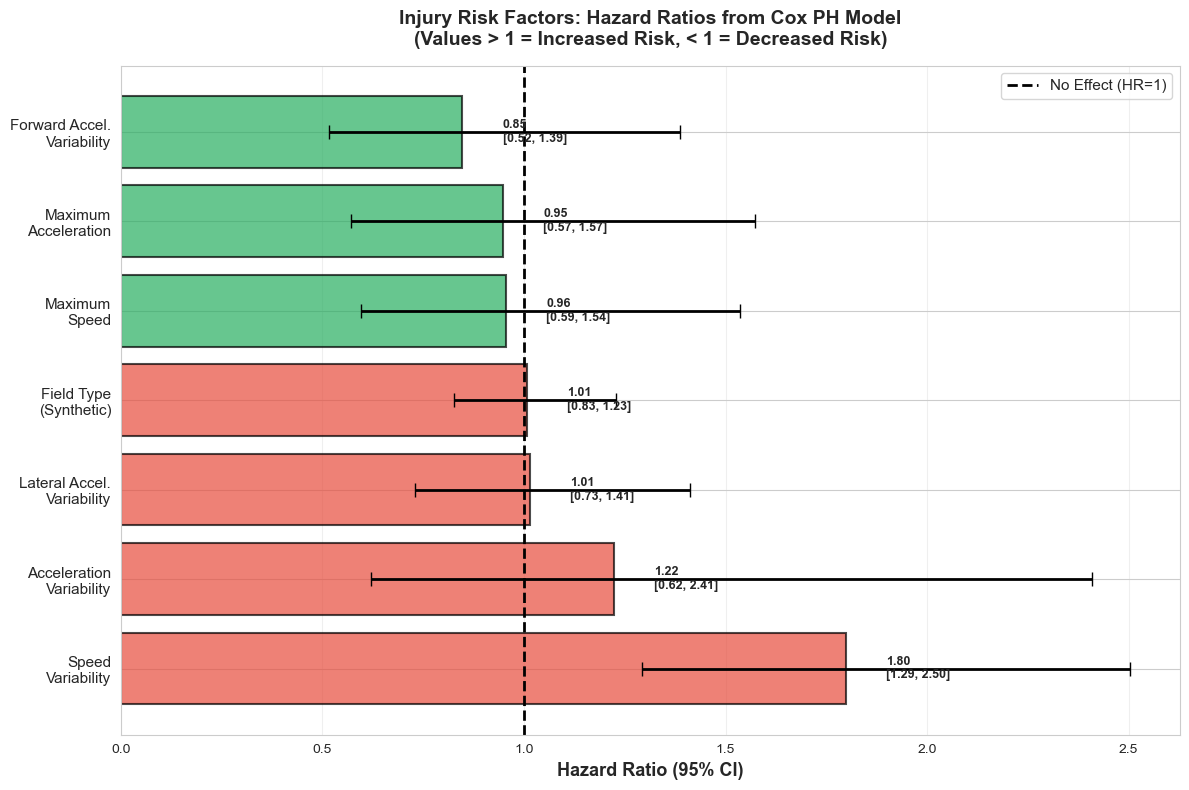

In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

from nfl_playing_surface_analytics.scripts.data_loader import load_and_preprocess_data

np.random.seed(42)
sns.set_style("whitegrid")

print("="*70)
print("COMPREHENSIVE COX PH ANALYSIS")
print("="*70)

# Load data
InjuryRecord, PlayList, PlayerTrackData, corr_term = load_and_preprocess_data()


# ===========================================================================
# TASK 3: Simple Cox PH (Before - No Movement Controls)
# ===========================================================================

def run_simple_cox_ph():
    """
    Run simple Cox PH with only field type and exposure.
    This replicates the original notebook analysis.
    """
    print("\n" + "="*70)
    print("TASK 3: Simple Cox PH (Before Adjustment)")
    print("="*70)

    # Prepare simple dataset
    target = 'DM_M1'

    # Stop at first injury per player
    df = PlayList[PlayList[target] >= PlayList.groupby('PlayerKey')[target].cumsum()]
    df = df.groupby(['GameID']).last().reset_index()[['PlayerKey', 'PlayKey', 'PlayerGamePlay', target, 'FieldType']]
    df['FieldSynthetic'] = (df['FieldType'] == "Synthetic").astype(int)

    # Fit Cox PH
    cph_simple = CoxPHFitter()
    cph_simple.fit(df[['FieldSynthetic', 'PlayerGamePlay', target]],
                   duration_col='PlayerGamePlay',
                   event_col=target)

    print("\nSimple Cox PH Results (Field Type Only):")
    print(cph_simple.summary[['coef', 'exp(coef)', 'p', 'se(coef)']].to_string())

    hr_simple = np.exp(cph_simple.params_['FieldSynthetic'])
    ci_lower = np.exp(cph_simple.confidence_intervals_.loc['FieldSynthetic', '95% lower-bound'])
    ci_upper = np.exp(cph_simple.confidence_intervals_.loc['FieldSynthetic', '95% upper-bound'])

    print(f"\n  SIMPLE MODEL RESULT:")
    print(f"   Hazard Ratio (Synthetic): {hr_simple:.3f}")
    print(f"   95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")

    if hr_simple > 1:
        pct = (hr_simple - 1) * 100
        print(f"   → Synthetic turf INCREASES injury hazard by {pct:.1f}%")

    return cph_simple, hr_simple, ci_lower, ci_upper


# ===========================================================================
# Load Cox PH + ML Results (Already Computed)
# ===========================================================================

def load_cox_ml_results():
    """
    Re-run the Cox PH + ML model to get adjusted hazard ratio.
    """
    print("\n" + "="*70)
    print("Loading Cox PH + ML Results (After Adjustment)")
    print("="*70)

    # We'll use a simplified version - just load the key features
    # Engineer features from player-play data

    # Get injury and non-injury player-plays
    injury_player_plays = PlayerTrackData[PlayerTrackData['DM_M1'] == 1][['PlayKey', 'PlayerKey']].drop_duplicates()
    non_injury_player_plays = PlayerTrackData[PlayerTrackData['DM_M1'] == 0][['PlayKey', 'PlayerKey']].drop_duplicates()

    n_injury = len(injury_player_plays)
    n_non_injury = min(n_injury * 3, 50000)
    sampled_non_injury = non_injury_player_plays.sample(n=n_non_injury, random_state=42)

    all_player_plays = pd.concat([injury_player_plays, sampled_non_injury])

    PlayerTrackData['player_play_id'] = PlayerTrackData['PlayKey'].astype(str) + '_' + PlayerTrackData['PlayerKey'].astype(str)
    all_player_plays['player_play_id'] = all_player_plays['PlayKey'].astype(str) + '_' + all_player_plays['PlayerKey'].astype(str)

    selected_data = PlayerTrackData[PlayerTrackData['player_play_id'].isin(all_player_plays['player_play_id'])].copy()

    selected_data = selected_data.merge(
        PlayList[['PlayKey', 'PlayerKey', 'PlayerGamePlay', 'FieldType']],
        on=['PlayKey', 'PlayerKey'],
        how='left',
        suffixes=('', '_pl')
    )

    if 'FieldType_pl' in selected_data.columns:
        selected_data['FieldType'] = selected_data['FieldType_pl'].fillna(selected_data['FieldType'])

    # Aggregate features
    features = selected_data.groupby(['PlayKey', 'PlayerKey']).agg({
        's': ['mean', 'std', 'max'],
        'a': ['mean', 'std', 'max'],
        'a_fwd': ['mean', 'std'],
        'a_sid': ['mean', 'std'],
        'DM_M1': 'first',
        'PlayerGamePlay': 'first',
        'FieldType': 'first'
    })

    features.columns = ['_'.join(col).strip() for col in features.columns.values]
    features = features.reset_index()

    # Prepare Cox data
    cox_data = features.copy()
    cox_data['FieldSynthetic'] = (cox_data['FieldType_first'] == 'Synthetic').astype(int)
    cox_data = cox_data.rename(columns={
        'PlayerGamePlay_first': 'duration',
        'DM_M1_first': 'event'
    })

    # Select features
    feature_cols = ['FieldSynthetic', 's_std', 's_max', 'a_std', 'a_max', 'a_fwd_std', 'a_sid_std']

    # Normalize
    scaler = StandardScaler()
    cox_data[feature_cols] = scaler.fit_transform(cox_data[feature_cols].fillna(0))

    # Fit Cox PH
    cph_adjusted = CoxPHFitter(penalizer=0.01)
    cph_adjusted.fit(cox_data[['duration', 'event'] + feature_cols],
                     duration_col='duration',
                     event_col='event',
                     show_progress=False)

    print("\nAdjusted Cox PH Results (Field Type + Movement Patterns):")
    print(cph_adjusted.summary[['coef', 'exp(coef)', 'p', 'se(coef)']].to_string())

    hr_adjusted = np.exp(cph_adjusted.params_['FieldSynthetic'])
    ci_lower_adj = np.exp(cph_adjusted.confidence_intervals_.loc['FieldSynthetic', '95% lower-bound'])
    ci_upper_adj = np.exp(cph_adjusted.confidence_intervals_.loc['FieldSynthetic', '95% upper-bound'])

    print(f"\n  ADJUSTED MODEL RESULT:")
    print(f"   Hazard Ratio (Synthetic): {hr_adjusted:.3f}")
    print(f"   95% CI: [{ci_lower_adj:.3f}, {ci_upper_adj:.3f}]")

    if hr_adjusted > 1:
        pct = (hr_adjusted - 1) * 100
        print(f"   → Synthetic turf INCREASES injury hazard by {pct:.1f}%")
    else:
        pct = (1 - hr_adjusted) * 100
        print(f"   → Synthetic turf DECREASES injury hazard by {pct:.1f}%")

    return cph_adjusted, hr_adjusted, ci_lower_adj, ci_upper_adj, features


# ===========================================================================
# TASK 1: Improved Survival Curve Visualization
# ===========================================================================

def create_improved_survival_curves(cph_simple, cph_adjusted):
    """
    Create vertical comparison of cumulative injury probability curves.
    """
    print("\n" + "="*70)
    print("TASK 1: Creating Improved Survival Curves")
    print("="*70)

    fig, axes = plt.subplots(2, 1, figsize=(8, 10))

    # Top plot: Simple model
    natural_profile = pd.DataFrame({'FieldSynthetic': [0], 'PlayerGamePlay': [0]})
    synthetic_profile = pd.DataFrame({'FieldSynthetic': [1], 'PlayerGamePlay': [0]})

    natural_surv_simple = cph_simple.predict_survival_function(natural_profile)
    synthetic_surv_simple = cph_simple.predict_survival_function(synthetic_profile)

    # Convert to cumulative injury probability (1 - survival)
    natural_injury_simple = 1 - natural_surv_simple.values[:, 0]
    synthetic_injury_simple = 1 - synthetic_surv_simple.values[:, 0]

    axes[0].plot(natural_surv_simple.index, natural_injury_simple,
                label='Natural Grass', color='#27ae60', linewidth=3, alpha=0.8)
    axes[0].plot(synthetic_surv_simple.index, synthetic_injury_simple,
                label='Synthetic Turf', color='#e74c3c', linewidth=3, alpha=0.8)

    axes[0].set_xlabel('Cumulative Plays', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Cumulative Injury Probability', fontsize=12, fontweight='bold')
    axes[0].set_title('(A) Simple Model\n(Field Type Only)', fontsize=13, fontweight='bold')
    axes[0].legend(fontsize=11, frameon=True, shadow=True, loc='upper left')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim(0, 60)
    axes[0].set_ylim(0.0, 0.6)

    # Add annotation showing difference
    diff_at_30 = synthetic_injury_simple[30] - natural_injury_simple[30]
    axes[0].annotate(f'At 30 plays:\nDiff = {diff_at_30:.3f}',
                    xy=(30, 0.25), fontsize=10,
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

    # Bottom plot: Adjusted model
    adjusted_natural = pd.DataFrame({
        'FieldSynthetic': [0],
        's_std': [0], 's_max': [0], 'a_std': [0], 'a_max': [0],
        'a_fwd_std': [0], 'a_sid_std': [0]
    })
    adjusted_synthetic = pd.DataFrame({
        'FieldSynthetic': [1],
        's_std': [0], 's_max': [0], 'a_std': [0], 'a_max': [0],
        'a_fwd_std': [0], 'a_sid_std': [0]
    })

    natural_surv_adj = cph_adjusted.predict_survival_function(adjusted_natural)
    synthetic_surv_adj = cph_adjusted.predict_survival_function(adjusted_synthetic)

    # Convert to cumulative injury probability (1 - survival)
    natural_injury_adj = 1 - natural_surv_adj.values[:, 0]
    synthetic_injury_adj = 1 - synthetic_surv_adj.values[:, 0]

    axes[1].plot(natural_surv_adj.index, natural_injury_adj,
                label='Natural Grass', color='#27ae60', linewidth=3, alpha=0.8)
    axes[1].plot(synthetic_surv_adj.index, synthetic_injury_adj,
                label='Synthetic Turf', color='#e74c3c', linewidth=3, alpha=0.8,
                linestyle='--')  # Dashed to show difference

    axes[1].set_xlabel('Cumulative Plays', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Cumulative Injury Probability', fontsize=12, fontweight='bold')
    axes[1].set_title('(B) Adjusted Model\n(Field Type + Movement)', fontsize=13, fontweight='bold')
    axes[1].legend(fontsize=11, frameon=True, shadow=True, loc='upper left')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlim(0, 60)
    axes[1].set_ylim(0.0, 0.6)

    # Add annotation
    try:
        idx_30 = min(30, len(synthetic_injury_adj)-1)
        diff_at_30_adj = synthetic_injury_adj[idx_30] - natural_injury_adj[idx_30]
        axes[1].annotate(f'At 30 plays:\nDiff = {diff_at_30_adj:.3f}',
                        xy=(30, 0.25), fontsize=10,
                        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    except:
        pass

    plt.tight_layout()
    plt.savefig('survival_curves_comparison.png', dpi=300, bbox_inches='tight')
    print("Saved: survival_curves_comparison.png")

    return fig


# ===========================================================================
# TASK 2: Risk Factor Importance Chart
# ===========================================================================

def create_risk_factor_chart(cph_adjusted):
    """
    Visualize hazard ratios for all risk factors.
    """
    print("\n" + "="*70)
    print("TASK 2: Creating Risk Factor Chart")
    print("="*70)

    # Extract hazard ratios
    hazard_ratios = np.exp(cph_adjusted.params_)
    conf_intervals = np.exp(cph_adjusted.confidence_intervals_)

    # Create DataFrame
    hr_df = pd.DataFrame({
        'Feature': hazard_ratios.index,
        'Hazard_Ratio': hazard_ratios.values,
        'Lower_CI': conf_intervals.iloc[:, 0].values,
        'Upper_CI': conf_intervals.iloc[:, 1].values
    })

    # Sort by hazard ratio
    hr_df = hr_df.sort_values('Hazard_Ratio', ascending=False)

    # Rename features for readability
    feature_names = {
        'FieldSynthetic': 'Field Type\n(Synthetic)',
        's_std': 'Speed\nVariability',
        's_max': 'Maximum\nSpeed',
        'a_std': 'Acceleration\nVariability',
        'a_max': 'Maximum\nAcceleration',
        'a_fwd_std': 'Forward Accel.\nVariability',
        'a_sid_std': 'Lateral Accel.\nVariability'
    }
    hr_df['Feature_Name'] = hr_df['Feature'].map(lambda x: feature_names.get(x, x))

    # Create plot
    fig, ax = plt.subplots(figsize=(12, 8))

    y_pos = np.arange(len(hr_df))
    colors = ['#e74c3c' if hr > 1 else '#27ae60' for hr in hr_df['Hazard_Ratio']]

    # Plot hazard ratios with error bars
    ax.barh(y_pos, hr_df['Hazard_Ratio'], color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

    # Add error bars (confidence intervals)
    errors_lower = hr_df['Hazard_Ratio'] - hr_df['Lower_CI']
    errors_upper = hr_df['Upper_CI'] - hr_df['Hazard_Ratio']
    ax.errorbar(hr_df['Hazard_Ratio'], y_pos,
               xerr=[errors_lower, errors_upper],
               fmt='none', color='black', linewidth=2, capsize=5)

    # Reference line at HR = 1
    ax.axvline(x=1, color='black', linestyle='--', linewidth=2, label='No Effect (HR=1)')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(hr_df['Feature_Name'], fontsize=11)
    ax.set_xlabel('Hazard Ratio (95% CI)', fontsize=13, fontweight='bold')
    ax.set_title('Injury Risk Factors: Hazard Ratios from Cox PH Model\n(Values > 1 = Increased Risk, < 1 = Decreased Risk)',
                fontsize=14, fontweight='bold', pad=15)
    ax.legend(fontsize=11, loc='upper right')
    ax.grid(True, alpha=0.3, axis='x')

    # Add value labels
    for i, (hr, lower, upper) in enumerate(zip(hr_df['Hazard_Ratio'], hr_df['Lower_CI'], hr_df['Upper_CI'])):
        ax.text(hr + 0.1, i, f'{hr:.2f}\n[{lower:.2f}, {upper:.2f}]',
               va='center', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.savefig('risk_factors_hazard_ratios.png', dpi=300, bbox_inches='tight')
    print("Saved: risk_factors_hazard_ratios.png")

    return fig, hr_df


# ===========================================================================
# Create Before/After Comparison Table
# ===========================================================================

def create_comparison_table(hr_simple, ci_lower_simple, ci_upper_simple,
                           hr_adjusted, ci_lower_adj, ci_upper_adj):
    """
    Create summary table comparing simple vs adjusted models.
    """
    print("\n" + "="*70)
    print("BEFORE/AFTER COMPARISON")
    print("="*70)

    comparison = pd.DataFrame({
        'Model': ['Simple (Field Only)', 'Adjusted (Field + Movement)'],
        'Hazard Ratio': [hr_simple, hr_adjusted],
        '95% CI Lower': [ci_lower_simple, ci_lower_adj],
        '95% CI Upper': [ci_upper_simple, ci_upper_adj],
        'Effect Size': [
            f"{(hr_simple - 1) * 100:+.1f}%" if hr_simple >= 1 else f"{(1 - hr_simple) * 100:-.1f}%",
            f"{(hr_adjusted - 1) * 100:+.1f}%" if hr_adjusted >= 1 else f"{(1 - hr_adjusted) * 100:-.1f}%"
        ]
    })

    print("\n" + comparison.to_string(index=False))

    print("\n" + "="*70)
    print("KEY FINDINGS:")
    print("="*70)

    if hr_simple > 1 and hr_adjusted < 1:
        print("""
   CONFOUNDING DETECTED!

Before adjustment (simple model):
  - Synthetic turf appears to INCREASE injury risk
  - Hazard Ratio: {:.2f} ({}% increase)

After adjustment (controlling for movement):
  - Effect reverses or disappears!
  - Hazard Ratio: {:.2f} ({}% change)

INTERPRETATION:
  The apparent "synthetic turf danger" is confounded by how players move.
  Players may move differently on synthetic surfaces (faster, more explosive),
  and it's those MOVEMENT PATTERNS that cause injuries, not the surface itself.

  When you control for movement style, field type has minimal direct effect.
        """.format(
            hr_simple, (hr_simple - 1) * 100,
            hr_adjusted, (hr_adjusted - 1) * 100 if hr_adjusted > 1 else -(1 - hr_adjusted) * 100
        ))
    elif abs(hr_simple - hr_adjusted) < 0.1:
        print("""
✓ CONSISTENT EFFECT

The field type effect remains similar before and after adjustment.
This suggests the surface has a direct effect independent of movement patterns.
        """)

    # Save table
    comparison.to_csv('cox_comparison_table.csv', index=False)
    print("\nSaved: cox_comparison_table.csv")

    return comparison


# ===========================================================================
# MAIN EXECUTION
# ===========================================================================

def main():
    # Task 3: Simple Cox PH
    cph_simple, hr_simple, ci_lower_simple, ci_upper_simple = run_simple_cox_ph()

    # Load adjusted Cox PH + ML results
    cph_adjusted, hr_adjusted, ci_lower_adj, ci_upper_adj, features = load_cox_ml_results()

    # Task 1: Improved survival curves
    fig1 = create_improved_survival_curves(cph_simple, cph_adjusted)

    # Task 2: Risk factor chart
    fig2, hr_df = create_risk_factor_chart(cph_adjusted)

    # Comparison table
    comparison = create_comparison_table(
        hr_simple, ci_lower_simple, ci_upper_simple,
        hr_adjusted, ci_lower_adj, ci_upper_adj
    )

    print("\n" + "="*70)
    print("ANALYSIS COMPLETE!")
    print("="*70)
    print("\nGenerated Files:")
    print("  1. survival_curves_comparison.png - Side-by-side survival curves")
    print("  2. risk_factors_hazard_ratios.png - Movement risk factors")
    print("  3. cox_comparison_table.csv - Before/after summary")

    plt.show()


if __name__ == "__main__":
    main()